## Causality Example A (Common driver): 

Here we demonstrate how a common driver can result in spurious correlations if not accounted for.

We show how the North Atlantic Oscillation (NAO) is independently correlated with summer precipitation
in Southern Europe (Italy and the Mediterranean) and Northern Europe (Denmark).

Without conditioning on NAO a spurious correlation exists between Southern and Northern Europe
precipitation.

For the causal analysis we use linear regression and also do a comparative analysis with the [DoWhy](https://github.com/microsoft/dowhy) package

The precipitation and NAO data were obtained from NOAA (NCEP [climate indices](https://psl.noaa.gov/data/climateindices/list/) and [reanalysis](https://psl.noaa.gov/cgi-bin/db_search/SearchMenus.pl?Dataset=CDC+Derived+NCEP+Reanalysis+Products+Other+Gaussian+Grid&Dataset=CDC+Derived+NCEP+Reanalysis+Products+Pressure+Level&Dataset=CDC+Derived+NCEP+Reanalysis+Products+Spectral&Dataset=CDC+Derived+NCEP+Reanalysis+Products+Surface+Flux&Dataset=CDC+Derived+NCEP+Reanalysis+Products+Surface+Level&Dataset=CDC+Derived+NCEP+Reanalysis+Products+Tropopause+Level&Dataset=NCEP+Reanalysis+Daily+Averages+Other+Gaussian+Grid&Dataset=NCEP+Reanalysis+Daily+Averages+Pressure+Level&Dataset=NCEP+Reanalysis+Daily+Averages+Surface+Flux&Dataset=NCEP+Reanalysis+Daily+Averages+Surface+Level&Dataset=NCEP+Reanalysis+Daily+Averages+Tropopause+Level&Dataset=NCEP+Reanalysis+Daily+Values&Dataset=NCEP+Reanalysis+Other+Gaussian+Grid&Dataset=NCEP+Reanalysis+Pressure+Level&Dataset=NCEP+Reanalysis+Surface+Flux&Dataset=NCEP+Reanalysis+Surface+Level&NCEP+Reanalysis+Tropopause+Level&group=1))



## Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import os

import iris

import iris.quickplot as qplt
import iris.coord_categorisation as coord_cat
import statsmodels.api as sm

import pandas as pd

import dowhy
from dowhy import CausalModel

## Step 1) Load and preprocess the data

In [4]:
nao = iris.load_cube('./sample_data/nao_jja.nc', 'nao')
precip = iris.load_cube('./sample_data/precip_jja.nc', 'Monthly Mean of Precipitation Rate')

## Step 2) Extract regions

### First region: Italy and the mediterranean 
from http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.368.3679&rep=rep1&type=pdf

In [6]:
med = precip.intersection(longitude=(10.0,30.0), latitude=(37.5, 45.0))

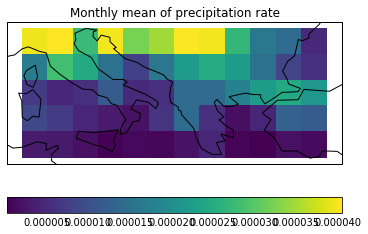

In [7]:
qplt.pcolormesh(med[0])
plt.gca().coastlines()

### Second region: Denmark

In [8]:
den = precip.intersection(longitude=(1.71873247, 14.87022484), latitude=(50.02227492, 60.60017151))

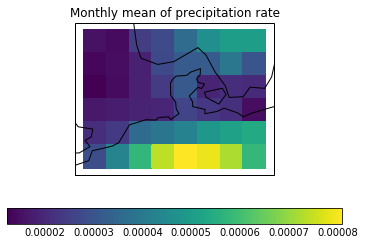

In [9]:
qplt.pcolormesh(den[0])
plt.gca().coastlines()

### Create regional means

In [10]:
def areal_mean(cube):
    grid_areas = iris.analysis.cartography.area_weights(cube)
    cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)
    return cube

In [11]:
# Areal mean
med = areal_mean(med)
den = areal_mean(den)

/data/share/causality_resources/envs/causality/lib/python3.6/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/data/share/causality_resources/envs/causality/lib/python3.6/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


In [12]:
# Constrain time range to 1950 - 2019
med = med.extract(iris.Constraint(coord_values={'season_year': lambda cell: 1950 <= cell <= 2019}))
den = den.extract(iris.Constraint(coord_values={'season_year': lambda cell: 1950 <= cell <= 2019}))
nao = nao.extract(iris.Constraint(coord_values={'Year': lambda cell: 1950 <= cell <= 2019}))

/data/share/causality_resources/envs/causality/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


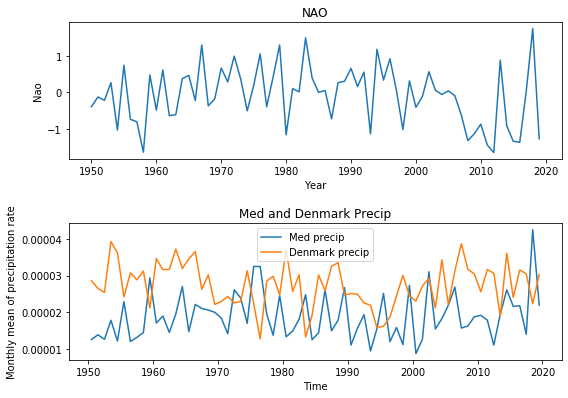

In [13]:
# PLOT raw data
fig = plt.figure(figsize=(8, 8))

plt.subplot(311)
qplt.plot(nao)
plt.title('NAO')

plt.subplot(312)
qplt.plot(med, label='Med precip')
qplt.plot(den, label='Denmark precip')
plt.subplot(312).legend()
plt.title("Med and Denmark Precip")
plt.tight_layout()


## Step 2) Data analysis using regression

In [14]:
# ================================
# CALC STANDARDIZED INDICES
# ================================

NAO = (nao - np.mean(nao.data))/np.std(nao.data)
MED = (med - np.mean(med.data))/np.std(med.data)
DEN = (den - np.mean(den.data))/np.std(den.data)

### Effect of NAO on Mediterranean Precip

In [15]:
Y = MED.data
X =  NAO.data

model = sm.OLS(Y,X)
results = model.fit()

print("effect of NAO on MED  =", round(results.params[0],2))

effect of NAO on MED  = 0.43


### Effect of NAO on Denmark Precip

In [16]:
Y = DEN.data
X =  NAO.data

model = sm.OLS(Y,X)
results = model.fit()

print("effect of NAO on DEN  =", round(results.params[0],2))

effect of NAO on DEN  = -0.55


### Unconditioned effect of Mediterranean Precip on Denmark Precip

In [17]:
Y = DEN.data
X =  MED.data

model = sm.OLS(Y,X)
results = model.fit()

print("effect of MED on DEN  =", round(results.params[0],2))

effect of MED on DEN  = -0.25


**This is spurious - they are not correlated!**

### Effect of Mediterranean Precip on Denmark Precip, conditioned on the confounder NAO

In [18]:
# MED <-- NAO --> DEN

Y = DEN.data
X = np.stack([NAO.data, MED.data]).T

model = sm.OLS(Y,X)
results = model.fit()


print("effect of NAO on DEN=", round(results.params[0],2))

print("effect of MED on DEN =", round(results.params[1],2))

effect of NAO on DEN= -0.55
effect of MED on DEN = -0.01


**By conditioning on the common cause, ENSO the spurious correlation is removed**

## Step 3) Data analysis using DoWhy

#### Assemble data into a dataframe

In [19]:
df = pd.DataFrame({'nao': NAO.data, 'med': MED.data, 'den': DEN.data}, columns=['nao', 'med', 'den'])
print(df.head(5))

        nao       med       den
0 -0.399534 -1.002663  0.203073
1 -0.061509 -0.802437 -0.151858
2 -0.179817 -0.995809 -0.341654
3  0.432854 -0.178690  2.001573
4 -1.206570 -1.070670  1.490477


#### Create the causal graph according to our assumptions

Here we have added a connection between Med and Denmark Precip
but include the common cause NAO directly in the graph so that
the true causal strength will be estimated


INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['med'] on outcome ['den']
INFO:dowhy.causal_graph:Using Matplotlib for plotting


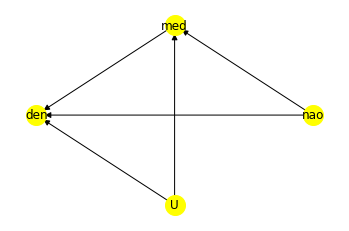

In [20]:
model=CausalModel(
        data = df,
        treatment='med',
        common_cause = 'nao',
        outcome='den',
        proceed_when_unidentifiable=True,
        graph="""graph[directed 1 node[id "nao" label "nao"]
                    node[id "med" label "med"]
                    node[id "den" label "den"]
                    edge[source "nao" target "med"]
                    edge[source "nao" target "den"]
                    edge[source "med" target "den"]]"""

        )
model.view_model()

In [21]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U', 'nao']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                         
──────(Expectation(den|nao))
d[med]                      
Estimand assumption 1, Unconfoundedness: If U→{med} and U→den then P(den|med,nao,U) = P(den|med,nao)
### Estimand : 2
Estimand name: iv
No such variable found!



In [22]:
estimate = model.estimate_effect(identified_estimand,
                                 test_significance=True,
                                 confidence_intervals=True,
                                 method_name="backdoor.linear_regression")
    
print("Causal Estimate is " + str(estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: den~med+nao


                            OLS Regression Results                            
Dep. Variable:                    den   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     14.66
Date:                Tue, 25 Aug 2020   Prob (F-statistic):           5.24e-06
Time:                        15:05:45   Log-Likelihood:                -86.622
No. Observations:                  70   AIC:                             179.2
Df Residuals:                      67   BIC:                             186.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.375e-16      0.102   6.26e-15      1.0

**We have estimated the effect correctly**

In [23]:
print(estimate.get_confidence_intervals())

[[-0.23649965  0.21437958]]


**The Table of results shows p-value for effect of med on den (x1) is >> 0.05 and p value for effect of nao on den (x2) is < 0.05**
**Therefore we have correctly identified that med has no significant effect on den, but nao does**